### Extract File Folders SKU 21 Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path  

my_data = pd.read_table('competition_data_2023_09_25.csv',delimiter=',')
sku_hist = my_data['sku'].unique()

for sku in sku_hist:
    if sku == "File Folders SKU 21":
        my_data_sku = my_data[my_data["sku"] == sku]

        filepath = Path("0926_my_data_sku_"+sku+".csv")  
        filepath.parent.mkdir(parents=True, exist_ok=True)  
        my_data_sku.to_csv(filepath, index=False)  
    
sku = "File Folders SKU 21"
path_file = "0926_my_data_sku_"+sku+".csv"
my_data_sku = pd.read_table(path_file,delimiter=',')
print(my_data_sku)



### Validate Model Coefficient

In [12]:
from sklearn.linear_model import LinearRegression

unitsordered = my_data_sku["unitsordered"].to_numpy().reshape([-1,1])
cogs         = my_data_sku["cogs"].to_numpy()
reg_1        = LinearRegression(fit_intercept=False).fit(unitsordered, cogs)
Residual     = (reg_1.predict(unitsordered) - cogs) ** 2
print("Residual Error for COG Estimation: ", np.mean(Residual))
print("Model coefficient for COG: ", reg_1.coef_[0])


unitsordered = my_data_sku["unitsordered"].to_numpy().reshape([-1,1])
fba          = my_data_sku["fba"].to_numpy()
reg_2        = LinearRegression(fit_intercept=False).fit(unitsordered, fba)
Residual     = (reg_2.predict(unitsordered) - fba) ** 2
print("Residual Error for FBA Estimation: ", np.mean(Residual))
print("Model coefficient for FBA: ", reg_2.coef_[0])


unitsordered = my_data_sku["unitsordered"].to_numpy().reshape([-1,1])
price        = my_data_sku["price"].to_numpy().reshape([-1,1])
reffee       = my_data_sku["reffee"].to_numpy()
reg_3        = LinearRegression(fit_intercept=False).fit(unitsordered*price, reffee)
Residual     = (reg_3.predict(unitsordered*price) - reffee) ** 2
print("Residual Error for reffee Estimation: ", np.mean(Residual))
print("Model coefficient for reffee: ", reg_3.coef_[0])

Residual Error for COG Estimation:  0.07405609714143363
Model coefficient for COG:  4.439714787344582
Residual Error for FBA Estimation:  0.07676785586538702
Model coefficient for FBA:  6.600931599125728
Residual Error for reffee Estimation:  0.07780544037761405
Model coefficient for reffee:  0.14995347007987989


In [13]:
from scipy.spatial.distance import cdist
import cvxpy as cp

def formulate_demand_pmf(price_Tr, comp_1_price_Tr, price_Te0, comp_1_price_Te0, sigma):
    # Non-parametric estimate of demand distribution
    #           Input:
    #        price_Tr: training samples for price
    # comp_1_price_Tr: training samples from competitor's price
    #       price_Te0: target price
    #comp_1_price_Te0: target competitor's price
    #           sigma: bandwidth
    #          Output:
    #      pmf_demand: pmf of demand distribution, supported on [demand_Tr]

    pmf_demand_exponent = (price_Te0 - price_Tr)**2 + (comp_1_price_Te0 - comp_1_price_Tr) ** 2
    pmf_demand = np.exp(-pmf_demand_exponent/sigma)
    pmf_demand = pmf_demand / np.sum(pmf_demand)
    return pmf_demand

def WDRO_demand_calculate(pmf_demand, unitsordered_Tr, price_Te0, epsilon):
    # WDRO Estimator of Robust Demand Distribution and Robust Profit
    #           Input:
    #      pmf_demand: nominal demand distribution
    # unitsordered_Tr: training samples for demand
    #       price_Te0: target price
    #         epsilon: size of ambiguity set
    #          Output:
    #               x: Robust Demand Distribution

    a_1=4.43965609
    a_2=6.60097822
    N = len(pmf_demand)
    cost_hist = 0.85*price_Te0*unitsordered_Tr - (a_1 + a_2) * unitsordered_Tr

    pmf_demand = pmf_demand.reshape([-1,1])
    cost_hist  = cost_hist.reshape([-1,1])
    unitsordered_Tr = unitsordered_Tr.reshape([-1,1])

    cost_unitsordered_Tr = cdist(unitsordered_Tr, unitsordered_Tr, 'sqeuclidean')
    x = cp.Variable(N)
    gamma = cp.Variable([N,N])

    obj = cp.Minimize(cost_hist.T@x)
    constrat = [gamma >=0, 
                cp.sum(cp.multiply(gamma, cost_unitsordered_Tr)) <= epsilon, 
                cp.sum(gamma,1) == pmf_demand.reshape([-1,]),
                cp.sum(gamma,0) == x]
    prob = cp.Problem(obj,constrat)
    prob.solve()
    return x.value, np.sum(x.value.reshape([-1,1]) * cost_hist), np.sum(pmf_demand * cost_hist)

def WDRO_demand_calculate_optimistic(pmf_demand, unitsordered_Tr, price_Te0, epsilon):
    # WDRO Estimator of Optimistic Demand Distribution and Optimistic Profit
    #           Input:
    #      pmf_demand: nominal demand distribution
    # unitsordered_Tr: training samples for demand
    #       price_Te0: target price
    #         epsilon: size of ambiguity set
    #          Output:
    #               x: Optimistic Demand Distribution

    a_1=4.43965609
    a_2=6.60097822
    N = len(pmf_demand)
    cost_hist = 0.85*price_Te0*unitsordered_Tr - (a_1 + a_2) * unitsordered_Tr

    pmf_demand = pmf_demand.reshape([-1,1])
    cost_hist  = cost_hist.reshape([-1,1])
    unitsordered_Tr = unitsordered_Tr.reshape([-1,1])

    cost_unitsordered_Tr = cdist(unitsordered_Tr, unitsordered_Tr, 'sqeuclidean')
    x = cp.Variable(N)
    gamma = cp.Variable([N,N])

    obj = cp.Maximize(cost_hist.T@x)
    constrat = [gamma >=0, 
                cp.sum(cp.multiply(gamma, cost_unitsordered_Tr)) <= epsilon, 
                cp.sum(gamma,1) == pmf_demand.reshape([-1,]),
                cp.sum(gamma,0) == x]
    prob = cp.Problem(obj,constrat)
    prob.solve()
    return x.value, np.sum(x.value.reshape([-1,1]) * cost_hist), np.sum(pmf_demand * cost_hist)


In [47]:
price                   = my_data_sku["price"].to_numpy()
unitsordered            = my_data_sku["unitsordered"].to_numpy()
comp_1_price            = my_data_sku["comp_1_price"].to_numpy()
managed_fba_stock_level = my_data_sku["managed_fba_stock_level"].to_numpy()


N_Te_size = 10
price_Tr                   = price[:-N_Te_size]
comp_1_price_Tr            = comp_1_price[:-N_Te_size]
unitsordered_Tr            = unitsordered[:-N_Te_size]
managed_fba_stock_level_Tr = managed_fba_stock_level[:-N_Te_size]

price_Te                   = price[-N_Te_size:]
comp_1_price_Te            = comp_1_price[-N_Te_size:]
unitsordered_Te            = unitsordered[-N_Te_size:]
managed_fba_stock_level_Te = managed_fba_stock_level[-N_Te_size:]



# Training data pre-processing
# #############################################################################################################
# Note: when unitsordered == managed_fba_stock_level, "unitsordered" no longer represents customer demand. 
#       Here we remove data points for this case to improve prediction performance
# #############################################################################################################
idx_hist = np.where(unitsordered_Tr < managed_fba_stock_level_Tr)

price_Tr_True        = price_Tr[idx_hist[0]]
comp_1_price_Tr_True = comp_1_price_Tr[idx_hist[0]]
unitsordered_Tr_True = unitsordered_Tr[idx_hist[0]]




### Cross Validation to Select Optimal epsilon and sigma (Note: Here we conduct it by further splitting training data into train-train and train-test datasets)

In [48]:
steps = 30
adspend                 = my_data_sku["adspend"].to_numpy()
adspend_Tr              = adspend[:-steps]
profit                  = my_data_sku["profit"].to_numpy()
profit_Tr               = profit[:-steps]



N_Te_size = 30

idx_Tr = idx_hist[0][:-N_Te_size]
idx_Te = idx_hist[0][-N_Te_size:]


price_Tr_True_Tr        = price_Tr[idx_Tr]
comp_1_price_Tr_True_Tr = comp_1_price_Tr[idx_Tr]
unitsordered_Tr_True_Tr = unitsordered_Tr[idx_Tr]

price_Tr_True_Te        = price_Tr[idx_Te]
comp_1_price_Tr_True_Te = comp_1_price_Tr[idx_Te]
unitsordered_Tr_True_Te = unitsordered_Tr[idx_Te]
adspend_Tr_Te           = adspend_Tr[idx_Te]
profit_Tr_Te            = profit_Tr[idx_Te]


sigma_hist = [0.01, 0.05, 0.1, 0.5, 1, 5, 10]
epsilon_hist = np.array([1, 5, 10, 15, 20, 25])

Eval_hist = []
for sigma in sigma_hist:
    for epsilon in epsilon_hist:
        print("simga: {}, epsilon: {}".format(sigma, epsilon))
        print("Prediction RMSE: ")



        Estimated_profit_hist = []
        True_profit_hist      = []
        for i in range(len(price_Tr_True_Te)):
            price_Te0        = price_Tr_True_Te[i]
            comp_1_price_Te0 = comp_1_price_Tr_True_Te[i]

            pmf_demand_Tr_Te = formulate_demand_pmf(price_Tr_True_Tr, comp_1_price_Tr_True_Tr, price_Te0, comp_1_price_Te0, sigma)
            pmf_demand_Tr_Te_robust, profit_robust, profit_ERM = WDRO_demand_calculate(pmf_demand_Tr_Te, unitsordered_Tr_True_Tr, price_Te0, epsilon**2)

            
            Estimated_profit_hist.append(profit_robust - adspend_Tr_Te[i])
            True_profit_hist.append(profit_Tr_Te[i])
        Estimated_profit_hist = np.array(Estimated_profit_hist)
        True_profit_hist      = np.array(True_profit_hist)
        RMSE = np.sqrt(np.mean((Estimated_profit_hist - True_profit_hist)**2))
        print(RMSE)
        Eval_hist.append([sigma, epsilon, RMSE])

Eval_hist = np.array(Eval_hist)


simga: 0.01, epsilon: 1
Prediction RMSE: 
49.30119989194364
simga: 0.01, epsilon: 5
Prediction RMSE: 
47.301270559043836
simga: 0.01, epsilon: 10
Prediction RMSE: 
54.26466468444131
simga: 0.01, epsilon: 15
Prediction RMSE: 
67.97231386862563
simga: 0.01, epsilon: 20
Prediction RMSE: 
81.8553893219105
simga: 0.01, epsilon: 25
Prediction RMSE: 
93.2170588341129
simga: 0.05, epsilon: 1
Prediction RMSE: 
47.14132690534043
simga: 0.05, epsilon: 5
Prediction RMSE: 
45.37748616851459
simga: 0.05, epsilon: 10
Prediction RMSE: 
53.722896657180016
simga: 0.05, epsilon: 15
Prediction RMSE: 
68.72920033486257
simga: 0.05, epsilon: 20
Prediction RMSE: 
85.16974574811059
simga: 0.05, epsilon: 25
Prediction RMSE: 
96.45456749482622
simga: 0.1, epsilon: 1
Prediction RMSE: 
48.247940207099816
simga: 0.1, epsilon: 5
Prediction RMSE: 
47.121823232143456
simga: 0.1, epsilon: 10
Prediction RMSE: 
56.045947443096
simga: 0.1, epsilon: 15
Prediction RMSE: 
71.41254196964636
simga: 0.1, epsilon: 20
Prediction

In [49]:
hyper_idx_opt = np.argmin(Eval_hist[:, 2])
print("Optimal hyper-parameter: ", Eval_hist[hyper_idx_opt, :2])
print("Estimated RMSE: ", Eval_hist[hyper_idx_opt,2])

Optimal hyper-parameter:  [0.05 5.  ]
Estimated RMSE:  45.37748616851459


In [60]:
N_Te_size = 30
price                   = my_data_sku["price"].to_numpy()
unitsordered            = my_data_sku["unitsordered"].to_numpy()
comp_1_price            = my_data_sku["comp_1_price"].to_numpy()
managed_fba_stock_level = my_data_sku["managed_fba_stock_level"].to_numpy()
adspend                 = my_data_sku["adspend"].to_numpy()
profit                  = my_data_sku["profit"].to_numpy()

unitsordered_Tr, unitsordered_Te            = unitsordered[:-N_Te_size], unitsordered[-N_Te_size:]
comp_1_price_Tr,  comp_1_price_Te           = comp_1_price[:-N_Te_size], comp_1_price[-N_Te_size:]
adspend_Tr, adspend_Te                      = adspend[:-N_Te_size], adspend[-N_Te_size:]
profit_Tr, profit_Te                        = profit[:-N_Te_size], profit[-N_Te_size:]
managed_fba_stock_level_Tr                  = managed_fba_stock_level[:-N_Te_size]
price_Tr, price_Te                          = price[:-N_Te_size], price[-N_Te_size:]

idx_hist = np.where(unitsordered_Tr < managed_fba_stock_level_Tr)

price_Tr_True        = price_Tr[idx_hist[0]]
comp_1_price_Tr_True = comp_1_price_Tr[idx_hist[0]]
unitsordered_Tr_True = unitsordered_Tr[idx_hist[0]]


# idx_hist                     = np.where(unitsordered < managed_fba_stock_level)
# price_Tr_True                = price[idx_hist[0]]
# unitsordered__Tr_True = unitsordered[idx_hist[0]]
# comp_1_price_True = comp_1_price[idx_hist[0]]
# adspend_True                 = adspend[idx_hist[0]]
# profit_True                  = profit[idx_hist[0]]

# N_Te_size = 10
# price_Tr, price_Te                          = price_True[:-N_Te_size], price_True[-N_Te_size:]





sigma = 1
epsilon = 5

Robust_profit_hist     = []
True_profit_hist       = []
Optimistic_profit_hist = []
for i in range(len(price_Te)):
    price_Te0        = price_Te[i]
    comp_1_price_Te0 = comp_1_price_Te[i]
    pmf_demand_Tr_Te = formulate_demand_pmf(price_Tr_True, comp_1_price_Tr_True, price_Te0, comp_1_price_Te0, sigma)
    pmf_demand_Tr_Te_robust, profit_robust, profit_ERM = WDRO_demand_calculate(pmf_demand_Tr_Te, unitsordered_Tr_True, price_Te0, epsilon**2)
    pmf_demand_Tr_Te_optimistic, profit_optimistic, profit_ERM = WDRO_demand_calculate_optimistic(pmf_demand_Tr_Te, unitsordered_Tr_True, price_Te0, epsilon**2)
    
    
    Robust_profit_hist.append(profit_robust - adspend_Te[i])
    True_profit_hist.append(profit_Te[i])
    Optimistic_profit_hist.append(profit_optimistic - adspend_Te[i])

Robust_profit_hist = np.array(Robust_profit_hist)
True_profit_hist      = np.array(True_profit_hist)
Optimistic_profit_hist = np.array(Optimistic_profit_hist)

print(Estimated_profit_hist)
print(True_profit_hist)
print(Optimistic_profit_hist)

[42.80639919 39.45784504 41.80639919 33.80639919 38.21198872 33.21198872
 34.21198872 50.61164139 53.39599832 56.39599832 59.39599832 56.80639919
 54.21198872 50.38712026 52.80639919 55.39599832 53.39599832 54.80639919
 51.11698658 49.11698658 50.11698658 54.11698658 54.11698658 56.11698658
 52.11698658 49.38712026 69.38712026 69.38712026 69.38712026 69.38712026]
[ 71. -10.  56. 108. 164. 184. 101.  81.  47.  10.  23.  36.  91. 107.
 111.  39.  11. 179.  70.  93. 143.  35.  35.  10.  65. 163. 112. 126.
  60.  37.]
[ 92.53162518  83.16629206  91.53162518  83.53162518  87.07794384
  82.07794384  83.07794384  98.61814828 103.98028285 106.98028285
 109.98028285 106.53162518 103.07794384  96.67438035 102.53162518
 105.98028285 103.98028285 104.53162518  95.68492853  93.68492853
  94.68492853  98.68492853  98.68492853 100.68492853  96.68492853
  95.67438035 115.67438035 115.67438035 115.67438035 115.67438035]


/Users/walter_rudin/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/walter_rudin/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[nan, 71.0, 30.5, 39.0, 56.25, 77.8, 95.5, 96.28571428571429, 97.71428571428571, 105.85714285714286, 99.28571428571429, 87.14285714285714, 68.85714285714286, 55.57142857142857, 56.42857142857143, 60.714285714285715, 59.57142857142857, 59.714285714285715, 82.0, 86.85714285714286, 87.14285714285714, 92.28571428571429, 81.42857142857143, 80.85714285714286, 80.71428571428571, 64.42857142857143, 77.71428571428571, 80.42857142857143, 78.0, 81.57142857142857]


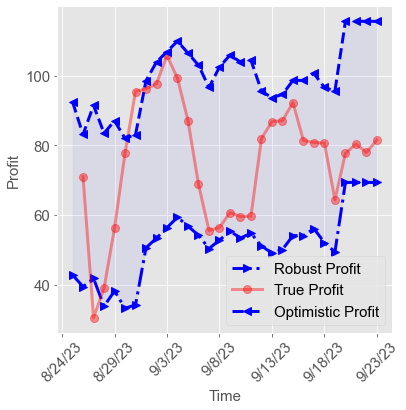

In [97]:
plt.rcParams["font.family"] = "arial"
plt.style.use("ggplot")
fig, axes = plt.subplots(figsize=(6,6))
x = np.arange(len(True_profit_hist)) + 1

True_profit_hist_updated = []

for i in range(len(True_profit_hist)):
    True_profit_hist_updated_i = np.mean(True_profit_hist[:i])

    if i >= 7:
        True_profit_hist_updated_i = np.mean(True_profit_hist[i-7:i])
    True_profit_hist_updated.append(True_profit_hist_updated_i)

print(True_profit_hist_updated)
axes.plot(x, Robust_profit_hist, label=r'Robust Profit', 
            linestyle = '-.', marker = '>', color='blue',ms=8,linewidth=3)
axes.plot(x, np.array(True_profit_hist_updated), label=r'True Profit', 
            linestyle = '-', marker = 'o', color='r',ms=8,linewidth=3,alpha=0.4)
axes.plot(x, Optimistic_profit_hist, label=r'Optimistic Profit', 
            linestyle = '--', marker = '<', color='blue',ms=8,linewidth=3)

axes.fill_between(x, 
                Robust_profit_hist, 
                Optimistic_profit_hist,
                color='blue',alpha=0.05)

axes.set_xticks([0,5,10,15,20,25,30])
axes.set_xticklabels([r'8/24/23',r'8/29/23',r'9/3/23',r'9/8/23',r'9/13/23',r'9/18/23',r'9/23/23'])
axes.set_xlabel('Time', fontsize=15)
axes.set_ylabel('Profit', fontsize=15)

plt.xticks(rotation = 45,fontsize=15)
plt.yticks(fontsize=15)

axes.legend(loc="best",fontsize=15)


plt.savefig("Profit_estimator.pdf",bbox_to_anchor="tight")